In [65]:
import os
import json
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy import stats

#### This notebook practices loading the version A MNI152 data and correlating it with the stimuli memorability scores in each ROI. The results are plotted and statistics are computed. This analysis reproduces the plot in Figure 8c.

<Axes: xlabel='task', ylabel='mem_score'>

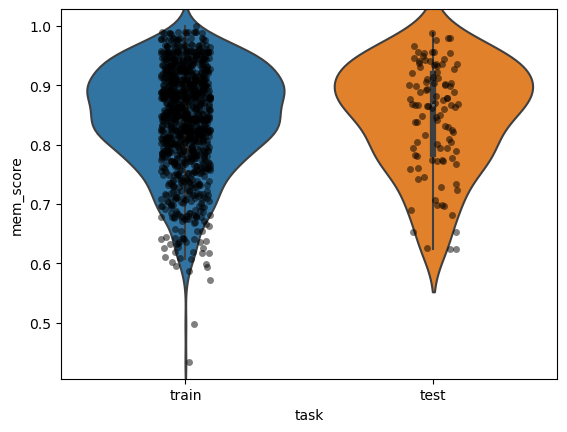

In [66]:
dataset_root = "/your/path/to/BOLDMoments"
beta_root = os.path.join(dataset_root,"derivatives","versionA","MNI152","prepared_data","prepared_allvoxel_pkl")

#load the metadata file
with open(os.path.join(dataset_root,"derivatives","stimuli_metadata","annotations.json"), 'r') as f:
    metadata = json.load(f)

# collect all the memorability scores into an array
mem_arr = np.array([metadata[f"{stim+1:04}"]['memorability_score'] for stim in range(1102)])
#organize the memorability scores by task and plot
data_plot = {'task': [], 'mem_score': []}
for i in range(1102):
    if i < 1000:
        data_plot['task'].append('train')
    elif i >= 1000:
        data_plot['task'].append('test')
        
    data_plot['mem_score'].append(metadata[f"{i+1:04}"]['memorability_score'])
df = pd.DataFrame(data=data_plot)
sns.violinplot(x="task",y="mem_score",data=data_plot)
sns.stripplot(x="task", y ="mem_score", data=data_plot, color="black", edgecolor="gray", alpha=0.5)

In [67]:
subjects= [f'sub-{s:02}' for s in range(1,11)]  #['sub-01','sub-02','sub-03','sub-04','sub-05','sub-06','sub-07','sub-08','sub-09','sub-10']
col = ['ROI','Correlation_Mean','Task','Subject'] 
data_plot = {c: [] for c in col} #initialize this dict that will later be turned to a pandas df for easy plotting

#roi memorability correlation
ROI_LUT = {'V1v': 1,'V1d': 2,'V2v': 3,'V2d': 4,'V3v': 5,'V3d': 6,'hV4': 7,'EBA': 8,'FFA': 9,'OFA': 10,'STS': 11,
               'LOC': 12,'PPA': 13,'RSC': 14,'TOS': 15,'V3ab': 16,'IPS0': 17,'IPS1-2-3': 18,
               '7AL': 19, 'BA2': 20, 'PFt': 21, 'PFop': 22}
for subject in subjects:
    print(subject)
    for ROI, LUT in ROI_LUT.items():
        #note that LUT is not used here. It is used if you equivalently want to load the "masterMask" and index the voxels from there.
        #load the ROI betas
        with open(os.path.join(beta_root, "TRavg56789", subject, f"{ROI}_TRavg-56789_allvoxel.pkl"), 'rb') as f:
            data = pickle.load(f)

        train_data = np.mean(data["train_data_allvoxel"],axis=1) #average across repetitions. shape (n_stimuli, n_reps, n_voxels)
        test_data = np.mean(data["test_data_allvoxel"],axis=1) #average across repetitions.  shape (n_stimuli, n_reps, n_voxels)
        num_voxels = data["train_data_allvoxel"].shape[2]
        betas = np.zeros((1102,num_voxels)) #initialize beta array
        
        betas[:1000,:] = train_data
        betas[1000:1102,:] = test_data
        del train_data, test_data, data
        #calculate observed correlation
        rho_obs=np.zeros(num_voxels)
        for v in tqdm(range(num_voxels)):
            spear_corr = stats.spearmanr(mem_arr, betas[:,v])
            rho_obs[v] = spear_corr[0]
        
        n = len(rho_obs)
        if n > 0: #if some voxels are not nan...
            data_plot['ROI'].append(ROI)
            data_plot['Correlation_Mean'].append(np.nanmean(rho_obs))
            data_plot['Task'].append("TestTrain")
            data_plot['Subject'].append(subject)
        else:
            print(f"subject {subject} roi {ROI}") #should just be sub-06 TOS and sub-07 TOS and RSC since those ROIs aren't defined for them.
            data_plot['ROI'].append(ROI)
            data_plot['Correlation_Mean'].append(np.nan)
            data_plot['Task'].append("TestTrain")
            data_plot['Subject'].append(subject)


sub-01


  0%|          | 0/320 [00:00<?, ?it/s]

100%|██████████| 222/222 [00:00<00:00, 1689.03it/s]


sub-02


100%|██████████| 222/222 [00:00<00:00, 1699.95it/s]


sub-03


100%|██████████| 222/222 [00:00<00:00, 1680.77it/s]


sub-04


100%|██████████| 220/220 [00:00<00:00, 1675.50it/s]


sub-05


100%|██████████| 220/220 [00:00<00:00, 1665.00it/s]


sub-06


100%|██████████| 713/713 [00:00<00:00, 1654.67it/s]
0it [00:00, ?it/s]


subject sub-06 roi TOS


100%|██████████| 222/222 [00:00<00:00, 1675.47it/s]


sub-07


100%|██████████| 84/84 [00:00<00:00, 1675.11it/s]
0it [00:00, ?it/s]


subject sub-07 roi RSC


0it [00:00, ?it/s]


subject sub-07 roi TOS


100%|██████████| 222/222 [00:00<00:00, 1686.12it/s]


sub-08


100%|██████████| 221/221 [00:00<00:00, 1682.62it/s]


sub-09


100%|██████████| 217/217 [00:00<00:00, 1681.13it/s]


sub-10


100%|██████████| 221/221 [00:00<00:00, 1676.50it/s]


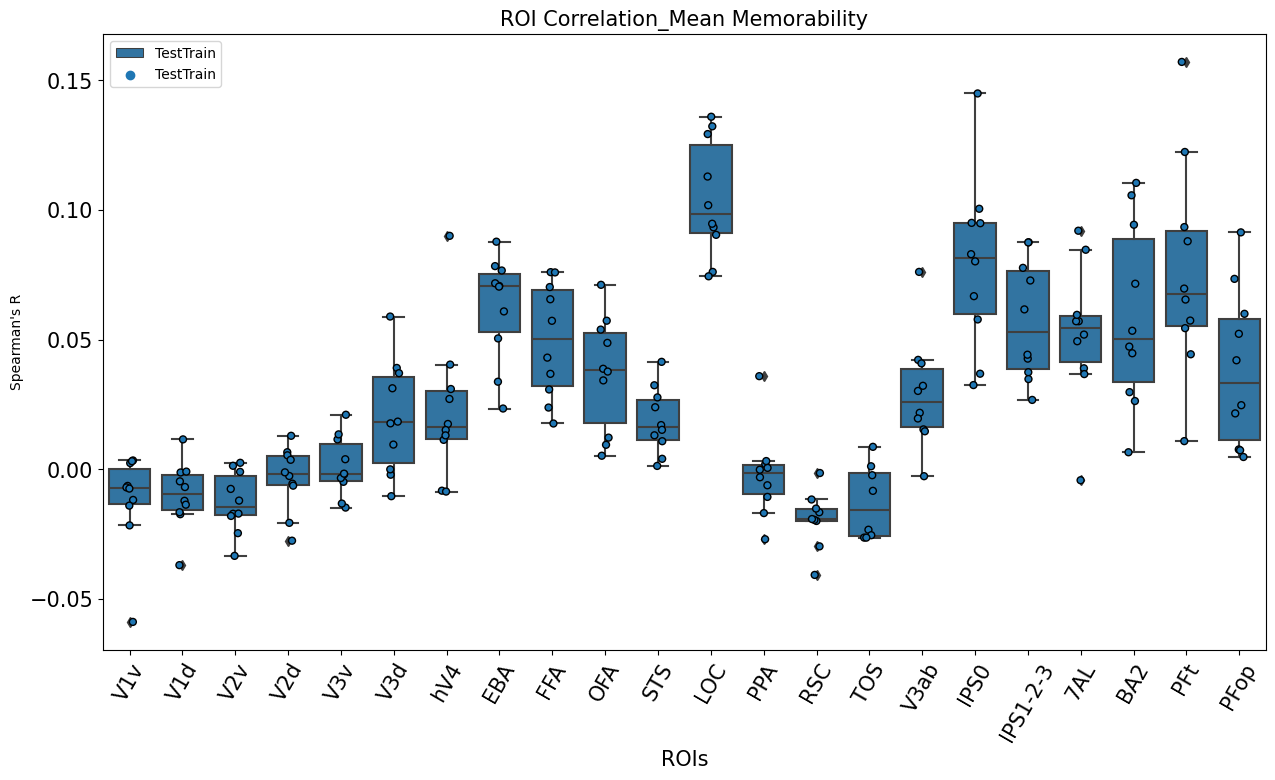

In [68]:
df = pd.DataFrame(data=data_plot) #convert dict to pandas dataframe
#plotting code
y_label = "Correlation_Mean"
ax = sns.boxplot(x="ROI", y=y_label, hue="Task", data=df)
sns.stripplot(x="ROI", y=y_label, hue="Task", data=df, edgecolor='black',linewidth=1)

fs = 15 #fontize
ax.set_title(f"ROI {y_label} Memorability", fontsize=fs)
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
ax.set_ylabel("Spearman's R")
ax.set_xlabel('ROIs', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
ax.legend().set_visible(True)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.show()

In [69]:
#compute statistics
#perform a one sample t-test for each ROI correlation against 0 correlation
alpha = 0.05/22 #bonferroni correct for 22 multiple comparisons
for ROI, lut in ROI_LUT.items(): #for each ROI
    df_roi = df[df['ROI']==ROI]
    roi_vals = df_roi.loc[:,'Correlation_Mean'].values
    if np.isnan(roi_vals).any(): 
        roi_vals = roi_vals[~np.isnan(roi_vals)]
    results = stats.ttest_1samp(roi_vals, popmean=0, nan_policy='raise', alternative='greater') #one-sided because we have a-priori reason to believe memorable stimuli result in higher magnitude of response
    pval = results[1]
    if pval < alpha:
        print(f"Memorability ROI {ROI} correlation mean is different from 0 with pvalue =", pval)

Memorability ROI EBA correlation mean is different from 0 with pvalue = 2.5224254351669525e-06
Memorability ROI FFA correlation mean is different from 0 with pvalue = 2.7667911352019246e-05
Memorability ROI OFA correlation mean is different from 0 with pvalue = 0.00025687435046888696
Memorability ROI STS correlation mean is different from 0 with pvalue = 0.000587041933037511
Memorability ROI LOC correlation mean is different from 0 with pvalue = 7.175080934318067e-08
Memorability ROI V3ab correlation mean is different from 0 with pvalue = 0.0009873998688225978
Memorability ROI IPS0 correlation mean is different from 0 with pvalue = 1.733300498219698e-05
Memorability ROI IPS1-2-3 correlation mean is different from 0 with pvalue = 1.2170594511562611e-05
Memorability ROI 7AL correlation mean is different from 0 with pvalue = 7.703870765279638e-05
Memorability ROI BA2 correlation mean is different from 0 with pvalue = 0.00025713598500145033
Memorability ROI PFt correlation mean is differen